## Introducción a CNNs

### Referencias
- LeCun, Y., Bengio, Y. and Hinton, G., 2015. [Deep Learning](https://www.nature.com/articles/nature14539). nature, 521(7553), pp.436-444.
- [Ignite documentation](https://pytorch-ignite.ai/)
- [PyTorch tutorials](https://pytorch.org/tutorials/) 
- [torchmetrics examples](https://torchmetrics.readthedocs.io/en/stable/pages/quickstart.html)
- [visdom](https://github.com/fossasia/visdom)


![pytorch cheatsheet](./figs/pytorch-cheat.jpeg "pytorch cheatsheet")

Figure from [pytorch forum](https://discuss.pytorch.org/t/pytorch-cheat-sheet/72016)

### Que pasos debemos seguir para entrenar una CNN?
- Cargar datos, transformarlos en formato necesario para pytorch. $t_{train}$ va a tener transformaciones diferentes a $t_{test}$, por que? 
- A los datos de entrenamiento debemos dividirlos una vez mas para usar elementos de validación durante el entrenamiento.
- Definir arquitectura de nuestra red (Ver models.py)
- Definir métodos funciones de error, optimizador y métricas de evaluación.

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, SubsetRandomSampler, ConcatDataset
from torchvision.datasets import MNIST
from torchvision.models import resnet18
from torchvision.transforms import Compose, Normalize, ToTensor
from sklearn.model_selection import KFold
import numpy as np
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, RunningAverage

#### Carga de datos, pre-procesamiento y definición de lotes

In [2]:
from torchvision import datasets
from torchvision import transforms as tfs
from torch.utils import data
import PIL

transforms_train = [
    tfs.RandomHorizontalFlip(p=0.7),
    tfs.RandomAffine(0, scale=(0.7, 1.0)),
    tfs.Resize((64, 64)),
    tfs.Grayscale(1),
    tfs.Lambda(lambda x: PIL.ImageOps.invert(x)),
    tfs.ToTensor(),
]

transforms_test = [
    tfs.RandomHorizontalFlip(p=0.7),
    tfs.RandomAffine(0, scale=(0.7, 1.0)),
    tfs.Resize((64, 64)),
    tfs.Grayscale(1),
    tfs.Lambda(lambda x: PIL.ImageOps.invert(x)),
    tfs.ToTensor(),
]

train_dataset = datasets.ImageFolder(
    "../data/train/", transform=tfs.Compose(transforms_train)
)

test_dataset = datasets.ImageFolder(
    "../data/test/", transform=tfs.Compose(transforms_test)
)

In [7]:
def setup_dataflow(dataset, train_idx, val_idx):
    """Funcion de inicialización para el dataset"""
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)

    train_loader = DataLoader(
        dataset, batch_size=64, sampler=train_sampler, drop_last=True
    )
    val_loader = DataLoader(dataset, batch_size=64, sampler=val_sampler, drop_last=True)

    return train_loader, val_loader

In [ ]:
train_loader, val_loader = setup_dataflow(train_dataset, train_idx, val_idx)

In [11]:
splits = data.random_split(train_dataset, [867, 96])
train_idx, val_idx = splits[0].indices, splits[1].indices

#### Ahora tenemos que definir modelo, función de error, optimizador, etc.


In [3]:
import torch.optim as optim
from torch import nn
from models import _C
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss
import torch.nn.functional as F
import torch
from aux import create_plot_window
import numpy as np

from ignite.contrib.handlers.tensorboard_logger import (
    global_step_from_engine,
    GradsHistHandler,
    GradsScalarHandler,
    TensorboardLogger,
    WeightsHistHandler,
    WeightsScalarHandler,
)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo disponible: {device}")

Dispositivo disponible: cuda


#### Cual es la arquitectura de nuestro modelo?

In [ ]:
%load models.py

In [6]:
def initialize():
    """Funcion de inicialización. Creamos el modelo, definimos el optimizador y la función de perdida"""
    model = _C(input_h_w=64).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.0002, betas=(0.5, 0.999))
    criterion = nn.CrossEntropyLoss()

    return model, optimizer, criterion

In [8]:
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter

#### Ignite para entrenamiento supervisado de la red
No se olviden de ver el dashboard the TensorBoard en [http://localhost:6006/](http://localhost:6006/)
Para iniciar el servidor del dashboard:

`tensorboard --logdir=./output --port 6006  --host 0.0.0.0 --load_fast=false`

In [10]:
def train_model(train_loader, val_loader, max_epochs=20, mode="training"):
    train_results = []
    val_results = []

    model, optimizer, criterion = initialize()

    now = datetime.now()
    logdir = "output/" + now.strftime("%Y%m%d-%H%M%S") + "/"
    writer = SummaryWriter(log_dir=logdir, flush_secs=1)

    trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
    evaluator = create_supervised_evaluator(
        model,
        metrics={"Accuracy": Accuracy(), "Loss": Loss(criterion)},
        device=device,
    )

    @trainer.on(Events.EPOCH_COMPLETED)
    def log_training_results(trainer):
        evaluator.run(train_loader)
        metrics = evaluator.state.metrics.copy()
        train_results.append(metrics)
        print(
            f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['Accuracy']:.2f} Avg loss: {metrics['Loss']:.2f}"
        )

    @trainer.on(Events.EPOCH_COMPLETED)
    def log_validation_results(trainer):
        evaluator.run(val_loader)
        metrics = evaluator.state.metrics.copy()
        val_results.append(metrics)

        writer.add_scalars(
            f"{mode}/Accuracy",
            {
                "val": val_results[trainer.state.epoch - 1]["Accuracy"],
                "train": train_results[trainer.state.epoch - 1]["Accuracy"],
            },
            trainer.state.epoch,
        )

        writer.add_scalars(
            f"{mode}/Loss",
            {
                "val": val_results[trainer.state.epoch - 1]["Loss"],
                "train": train_results[trainer.state.epoch - 1]["Loss"],
            },
            trainer.state.epoch,
        )

    trainer.run(train_loader, max_epochs=max_epochs)
    writer.close()

    return model, train_results, val_results

In [12]:
final_model, train_results, val_results = train_model(train_loader, val_loader, 100)

Training Results - Epoch[1] Avg accuracy: 0.35 Avg loss: 2.28
Training Results - Epoch[2] Avg accuracy: 0.62 Avg loss: 2.10
Training Results - Epoch[3] Avg accuracy: 0.72 Avg loss: 1.90
Training Results - Epoch[4] Avg accuracy: 0.77 Avg loss: 1.79
Training Results - Epoch[5] Avg accuracy: 0.80 Avg loss: 1.76
Training Results - Epoch[6] Avg accuracy: 0.80 Avg loss: 1.75
Training Results - Epoch[7] Avg accuracy: 0.80 Avg loss: 1.75
Training Results - Epoch[8] Avg accuracy: 0.80 Avg loss: 1.75
Training Results - Epoch[9] Avg accuracy: 0.81 Avg loss: 1.74
Training Results - Epoch[10] Avg accuracy: 0.83 Avg loss: 1.72
Training Results - Epoch[11] Avg accuracy: 0.85 Avg loss: 1.71
Training Results - Epoch[12] Avg accuracy: 0.84 Avg loss: 1.71
Training Results - Epoch[13] Avg accuracy: 0.84 Avg loss: 1.70
Training Results - Epoch[14] Avg accuracy: 0.85 Avg loss: 1.70
Training Results - Epoch[15] Avg accuracy: 0.85 Avg loss: 1.70
Training Results - Epoch[16] Avg accuracy: 0.87 Avg loss: 1.68
T

## 

#### Guardar arquitectura y pesos entrenados

In [13]:
torch.save(final_model.state_dict(), "./weights/classifier.pkl")

#### Bonus track: Cómo seria el entrenamiento de la misma red sin Ignite ?

`
epochs = 100

for epoch in range(epochs):
    running_loss = 0.0
    for i, (inputs, label) in enumerate(train_loader, 0):
        
        C_optimizer.zero_grad()
        inputs = inputs.to(device)

        # Forward Pass
        scores = C(inputs)
        loss = criterion(scores, label)

        # Backward Pass
        loss.backward()
        C_optimizer.step()

        running_loss += loss.data
        if i % 64 == 63:  # print every 64 mini-batches
            print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1, running_loss / 64))
            running_loss = 0.0
`

#### Como recuperamos los pesos entranados? 

In [25]:
final_model = _C(input_h_w=64).to(device)
final_model.load_state_dict(torch.load("./weights/classifier.pkl"))
final_model = final_model.eval()

#### Visualizacion de funciones de error y metricas del modelo entrenado

In [26]:
import matplotlib.pyplot as plt

plt.style.use(
    "https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle"
)

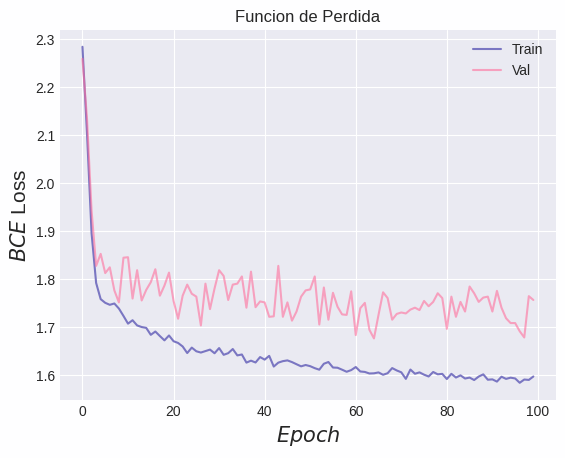

In [27]:
lossses_train = [t["Loss"] for t in train_results]
lossses_val = np.round([t["Loss"] for t in val_results], 3)

plt.plot(range(np.shape(lossses_train)[0]), lossses_train, "-", label="Train")
plt.plot(range(np.shape(lossses_val)[0]), lossses_val, "-", label="Val")
plt.title("Funcion de Perdida")
plt.xlabel("$Epoch$", fontsize=15)
plt.ylabel("$BCE$ Loss", fontsize=15)
plt.legend()

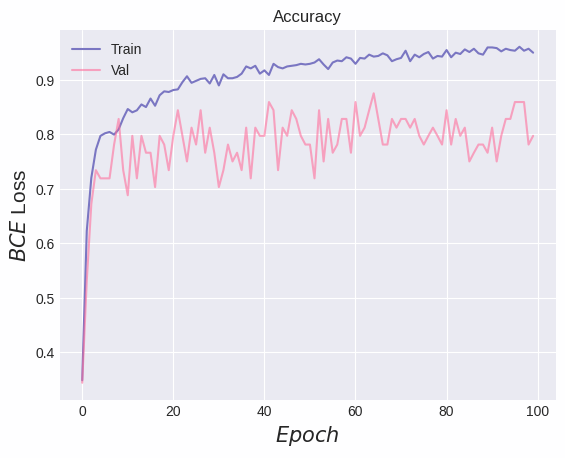

In [28]:
acc_train = [t["Accuracy"] for t in train_results]
acc_val = np.round([t["Accuracy"] for t in val_results], 3)

plt.plot(range(np.shape(acc_train)[0]), acc_train, "-", label="Train")
plt.plot(range(np.shape(acc_val)[0]), acc_val, "-", label="Val")
plt.title("Accuracy")
plt.xlabel("$Epoch$", fontsize=15)
plt.ylabel("$BCE$ Loss", fontsize=15)
plt.legend()

#### Métricas sobre el conjunto de datos de evaluación

In [29]:
test_loader = data.DataLoader(test_dataset, batch_size=64, shuffle=True)

##### Matriz de confusión

In [30]:
import torchnet

confusion_matrix = torchnet.meter.ConfusionMeter(11, normalized=True)

for ii, data_ in enumerate(test_loader):
    input_, label = data_
    val_input = input_.to(device)  # .cuda()
    val_label = label.type(torch.LongTensor).to(device)  # .cuda()
    score = final_model(val_input)
    confusion_matrix.add(score.data.squeeze(), label.type(torch.LongTensor))

np.set_printoptions(precision=3)
print(confusion_matrix.conf)

[[ 9  0  0  0  0  0  0  0  0  0  0]
 [ 0 83  2  1  0  0  0  0  0  1  0]
 [ 0  0 25  0  0  1  0  0  0  0  0]
 [ 1  0  0  8  0  0  0  0  0  5  0]
 [ 0  0  0  3 12  0  0  1  1  3  0]
 [ 0  0  1  1  1  0  0  0  0  0  0]
 [ 0  1  0  0  0  0 14  1  0  0  0]
 [ 0  0  0  3  0  0  1  6  0  7  0]
 [ 0  2  2  0  1  0  0  0 15  0  0]
 [ 0  0  0  5  3  0  0  0  0 93  0]
 [ 1  0  0  0  1  0  0  0  0  2  2]]


##### Recall, F1-Score, Precision

In [31]:
from aux import iterations_test
from sklearn import metrics

y_real, y_pred = iterations_test(final_model, test_loader, device)
print(metrics.classification_report(np.array(y_pred), np.array(y_real)))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       0.97      0.98      0.97        86
           2       0.92      0.89      0.91        27
           3       0.64      0.36      0.46        25
           4       0.80      0.73      0.76        22
           5       0.33      0.33      0.33         3
           6       0.94      0.94      0.94        16
           7       0.47      0.62      0.53        13
           8       0.70      0.93      0.80        15
           9       0.82      0.86      0.84        97
          10       0.50      0.60      0.55         5

    accuracy                           0.83       319
   macro avg       0.74      0.74      0.73       319
weighted avg       0.84      0.83      0.83       319



### Validación cruzada

In [32]:
dataset = ConcatDataset([train_dataset, test_dataset])

In [35]:
num_folds = 3
splits = KFold(n_splits=num_folds, shuffle=True, random_state=42)

In [36]:
results_per_fold = []

for fold_idx, (train_idx, val_idx) in enumerate(splits.split(np.arange(len(dataset)))):
    nro_fold = fold_idx + 1
    print("Fold {}".format(nro_fold))

    train_loader, val_loader = setup_dataflow(dataset, train_idx, val_idx)
    model, train_results, val_results = train_model(
        train_loader, val_loader, mode="Fold"
    )
    results_per_fold.append([train_results, val_results])

Fold 1
Training Results - Epoch[1] Avg accuracy: 0.56 Avg loss: 2.24
Training Results - Epoch[2] Avg accuracy: 0.63 Avg loss: 2.02
Training Results - Epoch[3] Avg accuracy: 0.71 Avg loss: 1.92
Training Results - Epoch[4] Avg accuracy: 0.75 Avg loss: 1.82
Training Results - Epoch[5] Avg accuracy: 0.76 Avg loss: 1.79
Training Results - Epoch[6] Avg accuracy: 0.77 Avg loss: 1.78
Training Results - Epoch[7] Avg accuracy: 0.77 Avg loss: 1.78
Training Results - Epoch[8] Avg accuracy: 0.80 Avg loss: 1.76
Training Results - Epoch[9] Avg accuracy: 0.80 Avg loss: 1.75
Training Results - Epoch[10] Avg accuracy: 0.80 Avg loss: 1.75
Training Results - Epoch[11] Avg accuracy: 0.84 Avg loss: 1.72
Training Results - Epoch[12] Avg accuracy: 0.83 Avg loss: 1.73
Training Results - Epoch[13] Avg accuracy: 0.82 Avg loss: 1.73
Training Results - Epoch[14] Avg accuracy: 0.84 Avg loss: 1.72
Training Results - Epoch[15] Avg accuracy: 0.84 Avg loss: 1.72
Training Results - Epoch[16] Avg accuracy: 0.84 Avg loss:

In [37]:
acc_sum = 0
for n_fold in range(len(results_per_fold)):
    current_fold = results_per_fold[n_fold]
    print(
        f"Validation Results - Fold[{n_fold + 1}] Avg accuracy: {current_fold[1][2]['Accuracy']:.2f} Avg loss: {current_fold[1][2]['Loss']:.2f}"
    )
    acc_sum += current_fold[1][2]["Accuracy"]

folds_mean = acc_sum / num_folds
print(f"Model validation average for {num_folds}-folds: {folds_mean :.2f}")

Validation Results - Fold[1] Avg accuracy: 0.70 Avg loss: 1.92
Validation Results - Fold[2] Avg accuracy: 0.70 Avg loss: 1.94
Validation Results - Fold[3] Avg accuracy: 0.69 Avg loss: 1.93
Model validation average for 3-folds: 0.70


##  Ejercicios

- Visualizar las funciones de error para distintos learning rates. Qué observan en los gráficos?
- Visualizar las funciones de error para distintos tamaños de lotes. 
- Visualizar subconjunto de elementos del grupo de evaluación con la clasificación y su puntaje respectivo.
- Comparar metricas de red entrenada en 10, 50 y 100 epochs. Qué diferencias observan?
- Re-entrenar un modelo preentrando `from torchvision import  models` para clasificacion, comparar sus resultados.